In [1]:
import os
import math
import random
from collections import Counter

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import sys

sys.path.append("..")

In [2]:
DATA_PATH = "../data/e_shop_clothing.csv"
df = pd.read_csv(DATA_PATH, sep=';', encoding='latin1')

print(df.head(10))
print(df.columns)

   year  month  day  order  country  session ID  page 1 (main category)  \
0  2008      4    1      1       29           1                       1   
1  2008      4    1      2       29           1                       1   
2  2008      4    1      3       29           1                       2   
3  2008      4    1      4       29           1                       2   
4  2008      4    1      5       29           1                       2   
5  2008      4    1      6       29           1                       3   
6  2008      4    1      7       29           1                       3   
7  2008      4    1      8       29           1                       4   
8  2008      4    1      9       29           1                       4   
9  2008      4    1      1       29           2                       2   

  page 2 (clothing model)  colour  location  model photography  price  \
0                     A13       1         5                  1     28   
1                     A16   

In [3]:
df = df.rename(columns=lambda x: x.strip())

cols_needed = ["session ID", "order", "page 2 (clothing model)"]
df = df[cols_needed]

df = df.sort_values(["session ID", "order"]).reset_index(drop=True)
df.head()

,session ID,order,page 2 (clothing model)
0,1,1,A13
1,1,2,A16
2,1,3,B4
3,1,4,B17
4,1,5,B8


In [4]:
item_col = "page 2 (clothing model)"
sess_col = "session ID"

item_counts = df[item_col].value_counts()
min_count = 3  # можно варьировать, чтобы отфильтровать редкие модели
frequent_items = item_counts[item_counts >= min_count].index

item2idx = {"<PAD>": 0, "<UNK>": 1}
for item in frequent_items:
    item2idx[item] = len(item2idx)

idx2item = {v: k for k, v in item2idx.items()}
vocab_size = len(item2idx)
vocab_size

215

In [5]:
def encode_item(x):
    return item2idx.get(x, item2idx["<UNK>"])


sessions = []

for sess_id, g in df.groupby(sess_col):
    items = g[item_col].tolist()
    if len(items) < 2:
        continue
    enc = [encode_item(it) for it in items]
    sessions.append(enc)

len(sessions), sessions[0][:10]

(18984, [21, 36, 2, 30, 123, 42, 73, 194, 84])

In [6]:
seqs = []
labels = []

for sess in sessions:
    for t in range(1, len(sess)):
        seqs.append(sess[:t])
        labels.append(sess[t])

len(seqs), len(labels)

(141448, 141448)

In [7]:
train_seqs, test_seqs, train_labels, test_labels = train_test_split(
    seqs, labels, test_size=0.1, random_state=42
)

train_seqs, val_seqs, train_labels, val_labels = train_test_split(
    train_seqs, train_labels, test_size=0.1, random_state=42
)

len(train_seqs), len(val_seqs), len(test_seqs)

MAX_TRAIN = 20000
MAX_VAL = 5000
MAX_TEST = 5000

train_seqs = train_seqs[:MAX_TRAIN]
train_labels = train_labels[:MAX_TRAIN]

val_seqs = val_seqs[:MAX_VAL]
val_labels = val_labels[:MAX_VAL]

test_seqs = test_seqs[:MAX_TEST]
test_labels = test_labels[:MAX_TEST]

In [8]:
from utils.dataset import SessionDataset, collate_fn

BATCH_SIZE = 128

train_ds = SessionDataset(train_seqs, train_labels)
val_ds = SessionDataset(val_seqs, val_labels)
test_ds = SessionDataset(test_seqs, test_labels)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         collate_fn=collate_fn)

In [9]:
from models.session_lstm import SessionLSTM

In [10]:
from utils.metrics import topk_accuracy

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EMBED_DIM = 64  # tunable
HIDDEN_SIZE = 128  # tunable
NUM_LAYERS = 1
DROPOUT = 0.2

model = SessionLSTM(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    pad_idx=item2idx["<PAD>"],
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

EPOCHS = 5  # tunable

In [12]:
def train_one_epoch(model, loader, optimizer, criterion, device, clip=5.0):
    model.train()
    total_loss = 0.0
    total_examples = 0

    for i, (input_ids, lengths, labels) in enumerate(loader):
        input_ids = input_ids.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, lengths)

        idx = (lengths - 1).unsqueeze(1).unsqueeze(2).expand(-1, 1, logits.size(-1))
        last_logits = logits.gather(1, idx).squeeze(1)

        loss = criterion(last_logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        batch_size = input_ids.size(0)
        total_loss += loss.item() * batch_size
        total_examples += batch_size

        if (i + 1) % 50 == 0:
            print(f"  batch {i + 1}/{len(loader)} | loss={loss.item():.4f}")

    return total_loss / total_examples


def evaluate(model, loader, criterion, device, k=5):
    model.eval()
    total_loss = 0.0
    total_examples = 0
    total_acc = 0.0

    with torch.no_grad():
        for input_ids, lengths, labels in loader:
            input_ids = input_ids.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)

            logits = model(input_ids, lengths)

            idx = (lengths - 1).unsqueeze(1).unsqueeze(2).expand(-1, 1, logits.size(-1))
            last_logits = logits.gather(1, idx).squeeze(1)

            loss = criterion(last_logits, labels)

            batch_size = input_ids.size(0)
            total_loss += loss.item() * batch_size
            total_examples += batch_size

            acc = topk_accuracy(last_logits, labels, k=k)
            total_acc += acc * batch_size

    return total_loss / total_examples, total_acc / total_examples

In [34]:
best_val_loss = float("inf")
best_model_path = "../models/best_session_lstm.pt"

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_top5 = evaluate(model, val_loader, criterion, device, k=5)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} | val_top5={val_top5:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("  -> saved best model")


Epoch 1/3
  batch 50/157 | loss=5.3090
  batch 100/157 | loss=5.2203
  batch 150/157 | loss=4.9144
Epoch 01 | train_loss=5.2009 | val_loss=4.9089 | val_top5=0.1648
  -> saved best model
Epoch 2/3
  batch 50/157 | loss=4.6912
  batch 100/157 | loss=4.6361
  batch 150/157 | loss=4.5026
Epoch 02 | train_loss=4.6730 | val_loss=4.4677 | val_top5=0.2332
  -> saved best model
Epoch 3/3
  batch 50/157 | loss=4.5149
  batch 100/157 | loss=4.5529
  batch 150/157 | loss=4.2499
Epoch 03 | train_loss=4.3392 | val_loss=4.2605 | val_top5=0.2776
  -> saved best model


In [36]:
best_val_loss = float("inf")
best_model_path = "../models/best_session_lstm.pt"

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_top5 = evaluate(model, val_loader, criterion, device, k=5)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} | val_top5={val_top5:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("  -> saved best model")

Epoch 1/5
  batch 50/157 | loss=5.1529
  batch 100/157 | loss=4.9077
  batch 150/157 | loss=4.7563
Epoch 01 | train_loss=5.0014 | val_loss=4.5676 | val_top5=0.2378
  -> saved best model
Epoch 2/5
  batch 50/157 | loss=4.4751
  batch 100/157 | loss=4.2434
  batch 150/157 | loss=4.2701
Epoch 02 | train_loss=4.3211 | val_loss=4.1872 | val_top5=0.3080
  -> saved best model
Epoch 3/5
  batch 50/157 | loss=4.0512
  batch 100/157 | loss=4.0409
  batch 150/157 | loss=4.0807
Epoch 03 | train_loss=4.0280 | val_loss=4.0543 | val_top5=0.3344
  -> saved best model
Epoch 4/5
  batch 50/157 | loss=3.8334
  batch 100/157 | loss=4.0752
  batch 150/157 | loss=3.9588
Epoch 04 | train_loss=3.8741 | val_loss=4.0014 | val_top5=0.3416
  -> saved best model
Epoch 5/5
  batch 50/157 | loss=3.9390
  batch 100/157 | loss=3.6023
  batch 150/157 | loss=3.7929
Epoch 05 | train_loss=3.7647 | val_loss=3.9752 | val_top5=0.3582
  -> saved best model


In [14]:
model.load_state_dict(torch.load('../models/best_session_lstm.pt', map_location=device))

test_loss, test_top5 = evaluate(model, test_loader, criterion, device, k=5)
print(f"Test loss: {test_loss:.4f}, Test top-5 hitrate: {test_top5:.4f}")

Test loss: 4.0370, Test top-5 hitrate: 0.3342


In [38]:
def recommend_next_items(model, session_items, k=5):
    model.eval()
    encoded = [encode_item(it) for it in session_items]
    input_ids = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)
    lengths = torch.tensor([len(encoded)], dtype=torch.long)

    input_ids = input_ids.to(device)
    lengths = lengths.to(device)

    with torch.no_grad():
        logits = model(input_ids, lengths)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits, dim=-1)
        topk_probs, topk_idx = probs.topk(k, dim=-1)

    topk_idx = topk_idx.squeeze(0).cpu().tolist()
    topk_probs = topk_probs.squeeze(0).cpu().tolist()

    rec_items = [idx2item[i] for i in topk_idx]
    return list(zip(rec_items, topk_probs))


example_raw_session = df[df[sess_col] == df[sess_col].iloc[0]][item_col].tolist()
example_raw_session

recommend_next_items(model, example_raw_session[:3], k=5)

[('B10', 0.054061032831668854),
 ('B4', 0.05251738801598549),
 ('B5', 0.04858376830816269),
 ('B17', 0.048043712973594666),
 ('B3', 0.04494721069931984)]

In [40]:
import matplotlib.pyplot as plt

EPOCHS = 5  # tunable
best_val_loss = float("inf")
best_model_path = "../models/best_session_lstm.pt"

history = {
    "train_loss": [],
    "val_loss": [],
    "val_top5": [],
}

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_top5 = evaluate(model, val_loader, criterion, device, k=5)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_top5"].append(val_top5)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} | val_top5={val_top5:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("  -> saved best model")

Epoch 1/5
  batch 50/157 | loss=3.6535
  batch 100/157 | loss=4.0069
  batch 150/157 | loss=3.5821
Epoch 01 | train_loss=3.6477 | val_loss=3.9724 | val_top5=0.3600
  -> saved best model
Epoch 2/5
  batch 50/157 | loss=3.4831
  batch 100/157 | loss=3.5400
  batch 150/157 | loss=3.6415
Epoch 02 | train_loss=3.5648 | val_loss=3.9718 | val_top5=0.3588
  -> saved best model
Epoch 3/5
  batch 50/157 | loss=3.4442
  batch 100/157 | loss=3.4183
  batch 150/157 | loss=3.5993
Epoch 03 | train_loss=3.4855 | val_loss=3.9818 | val_top5=0.3568
Epoch 4/5
  batch 50/157 | loss=3.4156
  batch 100/157 | loss=3.5646
  batch 150/157 | loss=3.3687
Epoch 04 | train_loss=3.4058 | val_loss=3.9948 | val_top5=0.3578
Epoch 5/5
  batch 50/157 | loss=3.1961
  batch 100/157 | loss=3.2257
  batch 150/157 | loss=3.3371
Epoch 05 | train_loss=3.3278 | val_loss=4.0152 | val_top5=0.3558


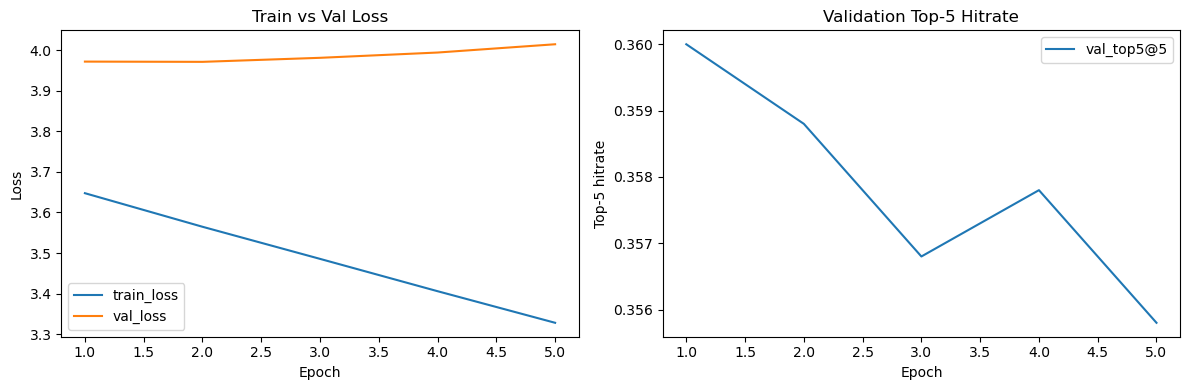

In [41]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history["val_top5"], label="val_top5@5")
plt.xlabel("Epoch")
plt.ylabel("Top-5 hitrate")
plt.title("Validation Top-5 Hitrate")
plt.legend()

plt.tight_layout()
plt.savefig("../results/loss_and_hitrate.png")  # Save the figure as a PNG file
plt.show()

In [15]:
EMBED_DIM = 64       # was 32
HIDDEN_SIZE = 128    # was 64
NUM_LAYERS = 2       # was 1
DROPOUT = 0.3        # was 0.2

model = SessionLSTM(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    pad_idx=item2idx["<PAD>"],
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

In [17]:
from copy import deepcopy

EPOCHS = 10
PATIENCE = 3  # how many epochs wait for improvement
best_val_loss = float("inf")
best_state_dict = None
epochs_no_improve = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=1, verbose=True
)

history = {
    "train_loss": [],
    "val_loss": [],
    "val_top5": [],
    "lr": [],
}

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_top5 = evaluate(model, val_loader, criterion, device, k=5)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_top5"].append(val_top5)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} | val_top5={val_top5:.4f} | "
          f"lr={optimizer.param_groups[0]['lr']:.1e}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        best_state_dict = deepcopy(model.state_dict())
        epochs_no_improve = 0
        print("  -> improved, saving state_dict in memory")
    else:
        epochs_no_improve += 1
        print(f"  no improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= PATIENCE:
        print("Early stopping triggered")
        break

# revive best model
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    torch.save(model.state_dict(), "../models/best_session_lstm_tuned_v2.pt")  # Updated file name for saved model

/Users/islammoldybayev/anaconda3/envs/deep_learning/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch 1/10
  batch 50/157 | loss=5.2315
  batch 100/157 | loss=5.1212
  batch 150/157 | loss=4.7216
Epoch 01 | train_loss=5.1641 | val_loss=4.8917 | val_top5=0.1398 | lr=5.0e-04
  -> improved, saving state_dict in memory

Epoch 2/10
  batch 50/157 | loss=4.8967
  batch 100/157 | loss=4.6360
  batch 150/157 | loss=4.5832
Epoch 02 | train_loss=4.7121 | val_loss=4.5366 | val_top5=0.1966 | lr=5.0e-04
  -> improved, saving state_dict in memory

Epoch 3/10
  batch 50/157 | loss=4.5250
  batch 100/157 | loss=4.3218
  batch 150/157 | loss=4.2028
Epoch 03 | train_loss=4.4110 | val_loss=4.3086 | val_top5=0.2556 | lr=5.0e-04
  -> improved, saving state_dict in memory

Epoch 4/10
  batch 50/157 | loss=4.2655
  batch 100/157 | loss=4.1993
  batch 150/157 | loss=3.9763
Epoch 04 | train_loss=4.2303 | val_loss=4.1842 | val_top5=0.2868 | lr=5.0e-04
  -> improved, saving state_dict in memory

Epoch 5/10
  batch 50/157 | loss=3.9176
  batch 100/157 | loss=4.1212
  batch 150/157 | loss=3.7663
Epoch 05 | 

In [18]:
test_loss, test_top5 = evaluate(model, test_loader, criterion, device, k=5)
print(f"Test loss: {test_loss:.4f}, Test top-5 hitrate: {test_top5:.4f}")

Test loss: 4.0438, Test top-5 hitrate: 0.3160
